Overview:

Step 1: Import required libraries

Step 2: Image loading and image Normalisation [size: (224,224,3)]

Step 3: Initialising, training and evaluation of MobileNetv2 model

Step 4: Initialising, training and evaluation of MobileNetv2 with self attention model

Step 5: Initialising, training and evaluation of MobileNetv2 with channel attention model

Step 6: Initialising, training and evaluation of MobileNetv2 with spatial attention model

Step 7: Initialising, training and evaluation of MobileNetv2 with CBAM attention model

Step 8: Classification image labelling visualisation

Step 9: GRAD CAM heatmap visualisation

In [1]:
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Reshape
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import metrics
import os
import re
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt

## Loading data

In [2]:
#loading all data into correct format

def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224)) #Input shape will change once images are processed
    img_array = np.array(img)
    return img_array

#pathnames
train_file = 'archive/train_annotations'
valid_file = 'archive/valid_annotations'
augmented_annotations = '5k_augmented_train_annotation.txt'


train_labels = []
train_images = []
train_image_file = []
val_labels = []
val_images = []

#adding original image train labels
with open(train_file, "r") as f:
    for line in f:
        category_ids = re.findall(r'"category_id": [1,2]', line)
    for id in category_ids:
        train_labels.append(int(id[-1]) - 1)

#adding original train images
for file in sorted(os.listdir('./archive/train/train/')):
    train_image_file.append(file)
    img_path = os.path.join('./archive/train/train/', file)   
    img = load_image(img_path)
    train_images.append(img)

#adding augmented train labels  
with open(augmented_annotations, "r") as f:
    content = f.read()
    aug_category_ids = re.findall(r'"augmented_\d+\.jpg","category_id":[1,2]', content)
    #making a list of all augmented image file names for next step
    img_files = re.findall(r'augmented_\d+\.jpg', content)
    for id in aug_category_ids:
        train_labels.append(int(id[-1]) - 1)

#adding augmented image files
for file in img_files:
    train_image_file.append(file)
    img_path = os.path.join('5k_train', file)   
    img = load_image(img_path)
    train_images.append(img)

#adding validation labels
with open(valid_file, "r") as f:
    for line in f:
        category_ids = re.findall(r'"category_id": [1,2]', line)
    for id in category_ids:
        val_labels.append(int(id[-1]) - 1)

#adding validation images
for file in sorted(os.listdir('./archive/valid/valid/')):
    img_path = os.path.join('./archive/valid/valid/', file)   
    img = load_image(img_path)
    val_images.append(img)

#numpy arrays of images and labels for both sets
train_images = np.array(train_images)
val_images = np.array(val_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

#Normalize
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0

### Evaluation metrics

In [4]:
def evaluation(model):
    val_predictions = model.predict(val_images)
    val_binary_predictions = (val_predictions > 0.5).astype(int)
    # Calculate all evaluation metrics
    conf_matrix = tf.math.confusion_matrix(val_labels, val_binary_predictions)
    accuracy = metrics.Accuracy()(val_labels, val_binary_predictions)
    precision = metrics.Precision()(val_labels, val_binary_predictions)
    recall = metrics.Recall()(val_labels, val_binary_predictions)
    f1 = 2 * (precision * recall) / (precision + recall)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Accuracy", accuracy.numpy())
    print("Precision:", precision.numpy())
    print("Recall:", recall.numpy())
    print("F1 Score:", f1.numpy())

## MobileNet v2 model

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*bqE59FvgpvoAQUMQ0WEoUA.png" art="vgg_image" width='600'/>

image from https://miro.medium.com/v2/resize:fit:720/format:webp/1*bqE59FvgpvoAQUMQ0WEoUA.png

In [5]:
#Getting pretrained MobileNetv2 model
input_shape = (224, 224, 3)
baseModel = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
#Freezing pretrained model layers
baseModel.trainable = False

In [6]:
#early stopping mechanism
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)  

In [7]:
#building MobileNetv2 model with new layers on the end to make it binary

lr = 1e-4
initial_model = keras.Sequential()
initial_model.add(baseModel)
initial_model.add(keras.layers.Flatten())
initial_model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
initial_model.add(keras.layers.Dropout(0.3))
initial_model.add(keras.layers.Dense(1, activation='sigmoid'))
initial_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])
#training
history = initial_model.fit(train_images, train_labels, batch_size=32, epochs=15, validation_data=(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/15
172/172 [==============================] - 29s 162ms/step - loss: 3.2446 - accuracy: 0.9698 - val_loss: 2.2643 - val_accuracy: 0.9306
Epoch 2/15
172/172 [==============================] - 27s 159ms/step - loss: 1.7095 - accuracy: 0.9967 - val_loss: 1.4647 - val_accuracy: 0.9583
Epoch 3/15
172/172 [==============================] - 27s 159ms/step - loss: 1.0773 - accuracy: 0.9987 - val_loss: 0.9945 - val_accuracy: 0.9583
Epoch 4/15
172/172 [==============================] - 28s 163ms/step - loss: 0.7381 - accuracy: 0.9924 - val_loss: 0.8020 - val_accuracy: 0.9583
Epoch 5/15
172/172 [==============================] - 27s 157ms/step - loss: 0.5391 - accuracy: 0.9938 - val_loss: 0.5952 - val_accuracy: 0.9444
Epoch 6/15
172/172 [==============================] - 27s 154ms/step - loss: 0.3818 - accuracy: 0.9987 - val_loss: 0.3867 - val_accuracy: 0.9583
Epoch 7/15
172/172 [==============================] - 27s 156ms/step - loss: 0.2626 - accuracy: 1.0000 - val_loss: 0.3126 - val_ac

## MobileNetv2 evaluation

In [8]:
evaluation(initial_model)

3/3 [==============================] - 1s 100ms/step
Confusion Matrix:
tf.Tensor(
[[34  2]
 [ 0 36]], shape=(2, 2), dtype=int32)
Accuracy 0.9722222
Precision: 0.94736844
Recall: 1.0
F1 Score: 0.972973


## MobileNetv2 with self-attention

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*LUE23j9u__ch3b8nTR5_wA.png" art="vgg_image" width='600'/>

image from https://miro.medium.com/v2/resize:fit:720/format:webp/1*LUE23j9u__ch3b8nTR5_wA.png

In [9]:
#Custom MobileNetV2 model with added attention layer and binary output

class AttentionMN(keras.models.Model):
    def __init__(self, input_shape):
        super(AttentionMN, self).__init__()
        #taking base model from MobileNetV2 and freezing layers
        self.baseModel = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        self.baseModel.trainable = False
   
        # attention layer
        self.attention_layer = tf.keras.layers.Attention(use_scale=True)
        # fully connected layers with dropout added
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(1, activation='sigmoid')

    
    def call(self, inputs):
        x = self.baseModel(inputs)
        x = self.attention_layer([x, x])
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        output = self.dense2(x)
        return output
    

In [10]:
input_shape = (224, 224, 3)
#Initialising custom model
att_model = AttentionMN(input_shape=input_shape)
x = Input(shape=(224, 224, 3))
attn_model = keras.models.Model(inputs=[x], outputs = att_model.call(x))

lr = 1e-4
attn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])

In [11]:
#training
history = attn_model.fit(train_images, train_labels, batch_size=32, epochs=15, validation_data=(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/15
172/172 [==============================] - 30s 168ms/step - loss: 3.5567 - accuracy: 0.9707 - val_loss: 2.6428 - val_accuracy: 0.9444
Epoch 2/15
172/172 [==============================] - 28s 161ms/step - loss: 2.0050 - accuracy: 0.9944 - val_loss: 1.9452 - val_accuracy: 0.9583
Epoch 3/15
172/172 [==============================] - 28s 163ms/step - loss: 1.2946 - accuracy: 0.9953 - val_loss: 1.3145 - val_accuracy: 0.9583
Epoch 4/15
172/172 [==============================] - 28s 163ms/step - loss: 0.8624 - accuracy: 0.9969 - val_loss: 0.8918 - val_accuracy: 0.9167
Epoch 5/15
172/172 [==============================] - 28s 164ms/step - loss: 0.6169 - accuracy: 0.9945 - val_loss: 0.8638 - val_accuracy: 0.9444
Epoch 6/15
172/172 [==============================] - 28s 164ms/step - loss: 0.4793 - accuracy: 0.9920 - val_loss: 0.5402 - val_accuracy: 0.9722
Epoch 7/15
172/172 [==============================] - 28s 165ms/step - loss: 0.3682 - accuracy: 0.9976 - val_loss: 0.5823 - val_ac

## Self-attention model evaluation

In [12]:
evaluation(attn_model)

3/3 [==============================] - 1s 99ms/step
Confusion Matrix:
tf.Tensor(
[[35  1]
 [ 1 35]], shape=(2, 2), dtype=int32)
Accuracy 0.9722222
Precision: 0.9722222
Recall: 0.9722222
F1 Score: 0.9722222


## MobileNetv2 with channel attention

<img src="https://miro.medium.com/v2/resize:fit:1400/0*WNEGJaXOZrNLtSv7" art="vgg_image" width='600'/>

image from https://miro.medium.com/v2/resize:fit:1400/0*WNEGJaXOZrNLtSv7

In [13]:
#Code from https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb
class ChannelAttention(tf.keras.layers.Layer):
  def __init__(self, filters, ratio):
    super(ChannelAttention, self).__init__()
    self.filters = filters
    self.ratio = ratio

  def build(self, input_shape):
    self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                                activation='relu', kernel_initializer='he_normal', 
                                use_bias=True, 
                                bias_initializer='zeros')
    self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                                kernel_initializer='he_normal',
                                use_bias=True,
                                bias_initializer='zeros')

  def call(self, inputs):
    # AvgPool
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


    avg_pool = self.shared_layer_one(avg_pool)
    avg_pool = self.shared_layer_two(avg_pool)

    # MaxPool
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
    max_pool = tf.keras.layers.Reshape((1,1,self.filters))(max_pool)

    max_pool = self.shared_layer_one(max_pool)
    max_pool = self.shared_layer_two(max_pool)


    attention = tf.keras.layers.Add()([avg_pool,max_pool])
    attention = tf.keras.layers.Activation('sigmoid')(attention)

    return tf.keras.layers.Multiply()([inputs, attention])

In [14]:
#Custom MobileNetv2 model with channel attention

class CAttentionMN(keras.models.Model):
    def __init__(self, input_shape):
        super(CAttentionMN, self).__init__()
        #taking base model from MobileNetv2 and freezing layers
        self.baseModel = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        self.baseModel.trainable = False

        # attention layer
        self.channel_attention = ChannelAttention(1280, 8)
        # fully connected layers with dropout added
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(1, activation='sigmoid')

    
    def call(self, inputs):
        x = self.baseModel(inputs)
        x = self.channel_attention(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        output = self.dense2(x)
        return output
    

In [15]:
input_shape = (224, 224, 3)
#Initialising custom model
cmodel = CAttentionMN(input_shape=input_shape)
x = Input(shape=(224, 224, 3))
c_model = keras.models.Model(inputs=[x], outputs = cmodel.call(x))

lr = 1e-4
c_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])



In [16]:
#training
history = c_model.fit(train_images, train_labels, batch_size=32, epochs=15, validation_data=(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/15
172/172 [==============================] - 30s 170ms/step - loss: 2.4229 - accuracy: 0.9773 - val_loss: 1.5644 - val_accuracy: 0.9583
Epoch 2/15
172/172 [==============================] - 28s 164ms/step - loss: 0.9897 - accuracy: 0.9958 - val_loss: 0.8917 - val_accuracy: 0.9583
Epoch 3/15
172/172 [==============================] - 28s 164ms/step - loss: 0.5777 - accuracy: 0.9969 - val_loss: 0.9999 - val_accuracy: 0.8611
Epoch 4/15
172/172 [==============================] - 29s 166ms/step - loss: 0.4175 - accuracy: 0.9927 - val_loss: 0.7005 - val_accuracy: 0.9444
Epoch 5/15
172/172 [==============================] - 29s 166ms/step - loss: 0.2905 - accuracy: 0.9971 - val_loss: 0.7846 - val_accuracy: 0.9444
Epoch 6/15
172/172 [==============================] - 28s 163ms/step - loss: 0.2124 - accuracy: 0.9965 - val_loss: 0.3793 - val_accuracy: 0.9583
Epoch 7/15
172/172 [==============================] - 28s 165ms/step - loss: 0.1777 - accuracy: 0.9956 - val_loss: 0.4190 - val_ac

## Channel attention model evaluation

In [17]:
evaluation(c_model)

3/3 [==============================] - 1s 96ms/step
Confusion Matrix:
tf.Tensor(
[[35  1]
 [ 1 35]], shape=(2, 2), dtype=int32)
Accuracy 0.9722222
Precision: 0.9722222
Recall: 0.9722222
F1 Score: 0.9722222


## MobileNetv2 with spatial attention

In [18]:
#Code from https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb
class SpatialAttention(tf.keras.layers.Layer):
  def __init__(self, kernel_size):
    super(SpatialAttention, self).__init__()
    self.kernel_size = kernel_size

  def build(self, input_shape):
    self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                      kernel_size=self.kernel_size,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_initializer='he_normal',
                      use_bias=False)

  def call(self, inputs):

  # AvgPool
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

    # MaxPool
    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

    attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

    attention = self.conv2d(attention)


    return tf.keras.layers.multiply([inputs, attention]) 

In [40]:
#Custom MobileNetv2 model with spatial attention

class SAttentionMN(keras.models.Model):
    def __init__(self, input_shape):
        super(SAttentionMN, self).__init__()
        #taking base model from MobileNetv2 and freezing layers
        self.baseModel = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        self.baseModel.trainable = False
 
        # attention layer
        self.spatial_attention = SpatialAttention(7)
        # fully connected layers with dropout added
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(1, activation='sigmoid')

    
    def call(self, inputs):
        x = self.baseModel(inputs)
        x = self.spatial_attention(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        output = self.dense2(x)
        return output

In [41]:
input_shape = (224, 224, 3)
#Initialising custom model
smodel = SAttentionMN(input_shape=input_shape)
x = Input(shape=(224, 224, 3))
s_model = keras.models.Model(inputs=[x], outputs = smodel.call(x))

lr = 1e-4
s_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])

In [42]:
#training
history = s_model.fit(train_images, train_labels, batch_size=32, epochs=15, validation_data=(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/15
172/172 [==============================] - 31s 174ms/step - loss: 2.7118 - accuracy: 0.9776 - val_loss: 1.6939 - val_accuracy: 0.9583
Epoch 2/15
172/172 [==============================] - 30s 177ms/step - loss: 1.1827 - accuracy: 0.9967 - val_loss: 0.9049 - val_accuracy: 0.9722
Epoch 3/15
172/172 [==============================] - 31s 181ms/step - loss: 0.6628 - accuracy: 0.9965 - val_loss: 0.8256 - val_accuracy: 0.9583
Epoch 4/15
172/172 [==============================] - 29s 169ms/step - loss: 0.4341 - accuracy: 0.9938 - val_loss: 0.4635 - val_accuracy: 0.9722
Epoch 5/15
172/172 [==============================] - 28s 165ms/step - loss: 0.2916 - accuracy: 0.9960 - val_loss: 0.7609 - val_accuracy: 0.8889
Epoch 6/15
172/172 [==============================] - 28s 164ms/step - loss: 0.2260 - accuracy: 0.9960 - val_loss: 0.2828 - val_accuracy: 0.9583
Epoch 7/15
172/172 [==============================] - 28s 165ms/step - loss: 0.1458 - accuracy: 0.9985 - val_loss: 0.3127 - val_ac

## Spatial attention model evaluation

In [43]:
evaluation(s_model)

3/3 [==============================] - 1s 106ms/step
Confusion Matrix:
tf.Tensor(
[[35  1]
 [ 1 35]], shape=(2, 2), dtype=int32)
Accuracy 0.9722222
Precision: 0.9722222
Recall: 0.9722222
F1 Score: 0.9722222


## MobileNetv2 Convolutional block attention model with both channel and spatial attention

In [36]:
#Custom MobileNetv2 model with CBAM

class CBAMAttentionMN(keras.models.Model):
    def __init__(self, input_shape):
        super(CBAMAttentionMN, self).__init__()
        #taking base model from MobileNetv2 and freezing layers
        self.baseModel = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        self.baseModel.trainable = False

        #attention layers
        self.channel_attention = ChannelAttention(1280, 8)
        self.spatial_attention = SpatialAttention(7)
        # fully connected layers with dropout added
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(1, activation='sigmoid')

    
    def call(self, inputs):
        x = self.baseModel(inputs)
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        output = self.dense2(x)
        return output
    

In [37]:
input_shape = (224, 224, 3)
#Initialising custom model
cbammodel = CBAMAttentionMN(input_shape=input_shape)
x = Input(shape=(224, 224, 3))
cbam_model = keras.models.Model(inputs=[x], outputs = cbammodel.call(x))

lr = 1e-4
cbam_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])

In [38]:
#training
history = cbam_model.fit(train_images, train_labels, batch_size=32, epochs=15, validation_data=(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/15
172/172 [==============================] - 31s 168ms/step - loss: 2.3862 - accuracy: 0.9735 - val_loss: 1.4173 - val_accuracy: 0.9722
Epoch 2/15
172/172 [==============================] - 28s 163ms/step - loss: 0.9118 - accuracy: 0.9969 - val_loss: 0.8568 - val_accuracy: 0.9444
Epoch 3/15
172/172 [==============================] - 28s 165ms/step - loss: 0.5165 - accuracy: 0.9978 - val_loss: 0.6408 - val_accuracy: 0.9722
Epoch 4/15
172/172 [==============================] - 28s 165ms/step - loss: 0.3291 - accuracy: 0.9969 - val_loss: 0.3892 - val_accuracy: 0.9722
Epoch 5/15
172/172 [==============================] - 28s 164ms/step - loss: 0.2297 - accuracy: 0.9960 - val_loss: 0.2619 - val_accuracy: 0.9861
Epoch 6/15
172/172 [==============================] - 29s 167ms/step - loss: 0.1913 - accuracy: 0.9947 - val_loss: 0.4552 - val_accuracy: 0.9583
Epoch 7/15
172/172 [==============================] - 29s 166ms/step - loss: 0.1317 - accuracy: 0.9982 - val_loss: 0.3864 - val_ac

## CBAM model evaluation

In [39]:
evaluation(cbam_model)

3/3 [==============================] - 1s 112ms/step
Confusion Matrix:
tf.Tensor(
[[35  1]
 [ 0 36]], shape=(2, 2), dtype=int32)
Accuracy 0.9861111
Precision: 0.972973
Recall: 1.0
F1 Score: 0.98630136


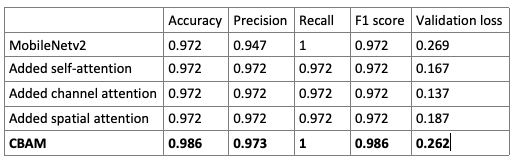

In [44]:

cbam_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 channel_attention_4 (Chann  (None, 7, 7, 1280)        411040    
 elAttention)                                                    
                                                                 
 spatial_attention_4 (Spati  (None, 7, 7, 1280)        98        
 alAttention)                                                    
                                                                 
 flatten_7 (Flatten)         (None, 62720)             0         
                                                          

## Classification visualisation example

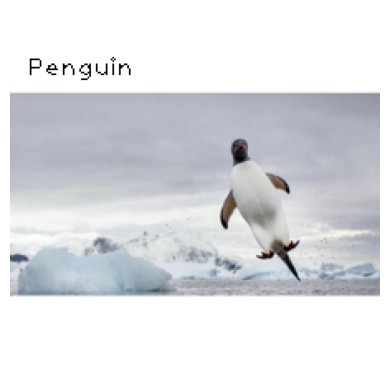

In [45]:
def visualisation(image, model):
    imageex = np.expand_dims(image, axis=0)
    output = model(imageex)
    if output[0] >= 0.5:
        caption = 'Turtle'
    else:
        caption = 'Penguin'
    imagecopy = image
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(imagecopy,caption,(10,40), font, 1, (0, 0, 0))
    plt.imshow(imagecopy)
    plt.axis('off')
    plt.show()


imageex = val_images[9]
visualisation(imageex, cbam_model)


        


## Attention visualisation with GRAD CAM

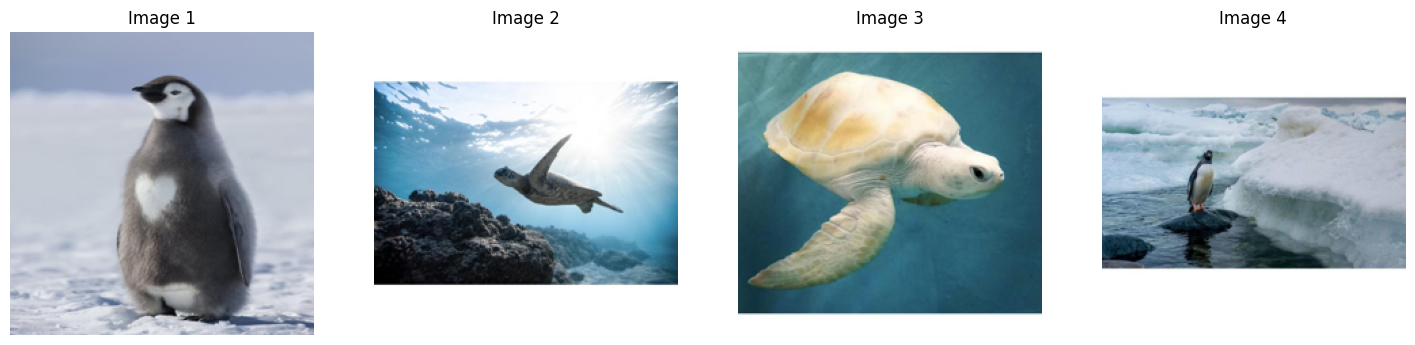

In [46]:
example1 = val_images[0]
example2 = val_images[44]
example3 = val_images[70]
example4 = val_images[56]

example_list = [example1, example2, example3, example4]


# example images
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for i in range(4):
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')
    axes[i].imshow(example_list[i])


plt.show()

In [47]:
#GRAD CAM visualisation adapted from https://www.kaggle.com/code/ayuraj/gradcam-implementation-visualization-in-tf-w-b

#creating GRAD CAM heatmap
def make_gradcam_heatmap(img_array, model):
    # create model to extract prediction and output of last conv layer
    grad_model = keras.models.Model(
        model.inputs, [model.layers[2].output, model.output]
    )

    # calculate gradients of loss on last conv layer
    with tf.GradientTape() as tape:
        (last_conv_outputs, preds) = grad_model(img_array)
        loss = preds[0]
    grads = tape.gradient(loss, last_conv_outputs)

    #taking only positive gradients 
    conv_outputs_binary = tf.cast(last_conv_outputs > 0, "float32")
    grads_binary = tf.cast(grads > 0, "float32")
    guidedGrads = conv_outputs_binary * grads_binary * grads

    #removing a dimension
    last_conv_outputs = last_conv_outputs[0]
    guidedGrads = guidedGrads[0]

    #Computing weights of each feature map
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    
    #Creating heatmap by taking sum of importance of each feature 
    heatmap = tf.reduce_sum(tf.multiply(weights, last_conv_outputs), axis=-1)
    
    #resizing heatmap to match image
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[2], img_array.shape[1]))
    #normalising and converting to uint8
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = np.uint8(heatmap*255)

    return heatmap


In [48]:
#overlaying heatmap on image
def overlay_gradcam(heatmap, image):
    heatmap_converted = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = np.uint8(image * 255)
    output = cv2.addWeighted(image, 0.5, heatmap_converted, 0.5, 0)
    return output


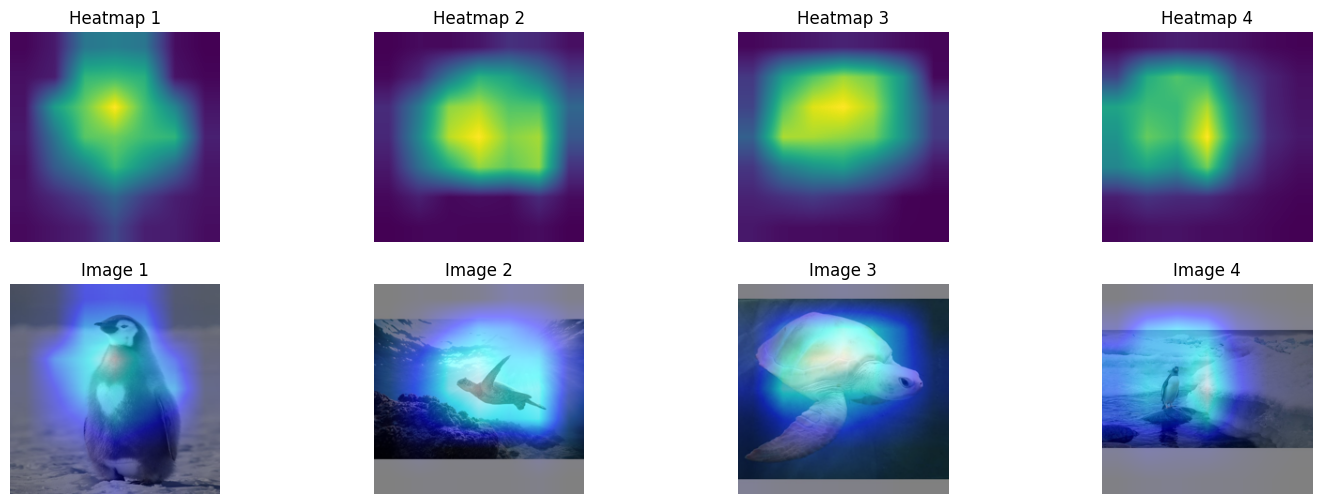

In [49]:
#showing heatmaps overlaid on images 
heatmap_list = []
overlay_list = []
for i in range(4):
    heatmap_list.append(make_gradcam_heatmap(np.expand_dims(example_list[i], axis=0), cbam_model))
    overlay_list.append(overlay_gradcam(heatmap_list[i], example_list[i]))


# example heatmaps
fig, axes = plt.subplots(2, 4, figsize=(18, 6))
for i in range(4):
    axes[1][i].axis('off') 
    axes[1][i].set_title(f'Image {i+1}')
    axes[1][i].imshow(overlay_list[i])
for i in range(4):
    axes[0][i].axis('off')
    axes[0][i].set_title(f'Heatmap {i+1}')
    axes[0][i].imshow(heatmap_list[i])